In [ ]:
import ast 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import statsmodels.api as sm
import matplotlib.dates as mdates

# Set the path to the file you'd like to load
file_path = 'M:/3_datasets/covid_19_data.csv'

# Load the latest version
df = pd.read_csv(file_path)

#clean
df.columns = df.columns.str.replace(' ', '_')
df['Last_Update'] = pd.to_datetime(df['Last_Update'], format='mixed') 
df['ObservationDate']= pd.to_datetime(df['ObservationDate'])

df.set_index('SNo', inplace=True)

df['Country/Region']= df['Country/Region'].fillna('else')
df['Province/State']= df['Province/State'].fillna('Unknown')

df[['Confirmed','Deaths','Recovered']] = df[['Confirmed','Deaths','Recovered']].clip(lower=0) 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306429 entries, 1 to 306429
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ObservationDate  306429 non-null  datetime64[ns]
 1   Province/State   306429 non-null  object        
 2   Country/Region   306429 non-null  object        
 3   Last_Update      306429 non-null  datetime64[ns]
 4   Confirmed        306429 non-null  float64       
 5   Deaths           306429 non-null  float64       
 6   Recovered        306429 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 18.7+ MB


In [3]:
df.head()

,ObservationDate,Province/State,Country/Region,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


In [4]:
df_US= df[df['Country/Region'] == 'US']
df_US

,ObservationDate,Province/State,Country/Region,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
32,2020-01-22,Washington,US,2020-01-22 17:00:00,1.0,0.0,0.0
72,2020-01-23,Washington,US,2020-01-23 17:00:00,1.0,0.0,0.0
122,2020-01-24,Washington,US,2020-01-24 17:00:00,1.0,0.0,0.0
123,2020-01-24,Chicago,US,2020-01-24 17:00:00,1.0,0.0,0.0
165,2020-01-25,Washington,US,2020-01-25 17:00:00,1.0,0.0,0.0
...,...,...,...,...,...,...,...
306396,2021-05-29,Virginia,US,2021-05-30 04:20:55,675165.0,11160.0,0.0
306406,2021-05-29,Washington,US,2021-05-30 04:20:55,435849.0,5765.0,0.0
306409,2021-05-29,West Virginia,US,2021-05-30 04:20:55,161287.0,2792.0,0.0


In [5]:
df_grouped = df_US.groupby(['Province/State', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].max().reset_index()

us_daily = df_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

us_daily


,ObservationDate,Confirmed,Deaths,Recovered
0,2020-01-22,1.0,0.0,0.0
1,2020-01-23,1.0,0.0,0.0
2,2020-01-24,2.0,0.0,0.0
3,2020-01-25,2.0,0.0,0.0
4,2020-01-26,5.0,0.0,0.0
...,...,...,...,...
489,2021-05-25,33166418.0,590941.0,0.0
490,2021-05-26,33190470.0,591950.0,0.0
491,2021-05-27,33217995.0,593288.0,0.0
492,2021-05-28,33239963.0,593963.0,0.0


In [6]:
us_daily['New_Confirmed'] = us_daily['Confirmed'].diff()
us_daily['New_Deaths'] = us_daily['Deaths'].diff()


## note about: .pct_change() * 100

### ✅ What this line does:

```python
us_daily['GrowthRate_Confirmed'] = us_daily['Confirmed'].pct_change() * 100
```

* `.pct_change()` calculates **the percentage change from the previous row**.
* So it measures **growth rate**, i.e., **how much the number increased or decreased** compared to the previous day.

Example:

| Day | Confirmed | pct_change() | GrowthRate_Confirmed |
| --- | --------- | ------------ | -------------------- |
| 1   | 100       | NaN          | NaN                  |
| 2   | 110       | 0.10         | 10.0 (%)             |
| 3   | 121       | 0.10         | 10.0 (%)             |
| 4   | 133       | 0.099        | 9.9 (%)              |

→ This tells you *how fast* cases are growing daily.

---

### ❌ What this line does:

```python
us_daily['GrowthRate_Confirmed'] = us_daily['Confirmed'] * 100
```

* This just **multiplies each value in the “Confirmed” column by 100**.
* It doesn’t calculate any growth — it only **scales the raw data** (e.g., 100 cases → 10,000).
* The name “GrowthRate” would then be **misleading**, because you’re not actually finding any rate.

Example:

| Day | Confirmed | Confirmed × 100 |
| --- | --------- | --------------- |
| 1   | 100       | 10,000          |
| 2   | 110       | 11,000          |
| 3   | 121       | 12,100          |

→ This is **not a rate**; it’s just the same data scaled by 100.

---

### 🧠 Summary:

| Formula               | Meaning                          | Used for                     |
| --------------------- | -------------------------------- | ---------------------------- |
| `.pct_change() * 100` | Daily **% change** (growth rate) | To analyze growth trends     |
| `* 100`               | Multiplies raw values by 100     | Just scaling, **not growth** |



In [7]:
us_daily['GrowthRate_Confirmed'] = us_daily['Confirmed'].pct_change() * 100
us_daily['GrowthRate_Deaths'] = us_daily['Deaths'].pct_change() * 100

us_daily= us_daily.fillna(0)
us_daily

,ObservationDate,Confirmed,Deaths,Recovered,New_Confirmed,New_Deaths,GrowthRate_Confirmed,GrowthRate_Deaths
0,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,2020-01-23,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2020-01-24,2.0,0.0,0.0,1.0,0.0,100.000000,0.000000
3,2020-01-25,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,2020-01-26,5.0,0.0,0.0,3.0,0.0,150.000000,0.000000
...,...,...,...,...,...,...,...,...
489,2021-05-25,33166418.0,590941.0,0.0,22756.0,621.0,0.068659,0.105197
490,2021-05-26,33190470.0,591950.0,0.0,24052.0,1009.0,0.072519,0.170745
491,2021-05-27,33217995.0,593288.0,0.0,27525.0,1338.0,0.082930,0.226033
492,2021-05-28,33239963.0,593963.0,0.0,21968.0,675.0,0.066133,0.113773


In [8]:
# Reshape data from wide → long format
us_melted = us_daily.melt(
    id_vars='ObservationDate', 
    value_vars=['GrowthRate_Confirmed', 'GrowthRate_Deaths'],
    var_name='Metric', 
    value_name='GrowthRate'
)

us_melted

,ObservationDate,Metric,GrowthRate
0,2020-01-22,GrowthRate_Confirmed,0.000000
1,2020-01-23,GrowthRate_Confirmed,0.000000
2,2020-01-24,GrowthRate_Confirmed,100.000000
3,2020-01-25,GrowthRate_Confirmed,0.000000
4,2020-01-26,GrowthRate_Confirmed,150.000000
...,...,...,...
983,2021-05-25,GrowthRate_Deaths,0.105197
984,2021-05-26,GrowthRate_Deaths,0.170745
985,2021-05-27,GrowthRate_Deaths,0.226033
986,2021-05-28,GrowthRate_Deaths,0.113773


## note about: set_major_locator & set_major_formatter

## 🧭 1️⃣ **`set_major_locator()`**

* **Purpose:** Controls **where** the *major* ticks (the big ticks on the axis) appear.
* You use this to decide **the positions of the main ticks**.

### Example:

```python
g.ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
```

➡️ `mdates.MonthLocator(interval=2)` means:

* Place a tick **every 2 months** on the x-axis (January, March, May, July, etc.).
* `set_major_locator()` applies that rule.

---

## 🧭 2️⃣ **`set_major_formatter()`**

* **Purpose:** Controls **how** those *major ticks* are **displayed (formatted)** — i.e., what text or label appears.
* You use this to customize **the text shown for each tick**.

### Example:

```python
g.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
```

➡️ `mdates.DateFormatter('%b-%Y')` means:

* Show the date in **month-year format**, like:

  * `Jan-2020`, `Mar-2020`, `May-2020`, etc.
* `%b` = short month name
* `%Y` = full year

---

## 🧭 3️⃣ **`mdates.MonthLocator`**

* Comes from `matplotlib.dates`.
* It decides **where to place date ticks**.
* You can control:

  * `interval` (e.g., every 1 month, every 2 months)
  * or specific months.

### Example:

```python
mdates.MonthLocator(interval=2)
```

➡️ Tick every 2 months.

```python
mdates.MonthLocator(bymonth=[1, 7])
```

➡️ Tick **only in January and July** each year.

---

## 🧭 4️⃣ **`mdates.DateFormatter`**

* Also from `matplotlib.dates`.
* It decides **how date values are displayed as strings**.

### Example:

```python
mdates.DateFormatter('%b-%Y')
```

➡️ Convert datetime like `2020-01-15` → `'Jan-2020'`.

Other formats:

* `'%Y-%m-%d'` → `2020-01-15`
* `'%b %d'` → `Jan 15`
* `'%b'` → `Jan`

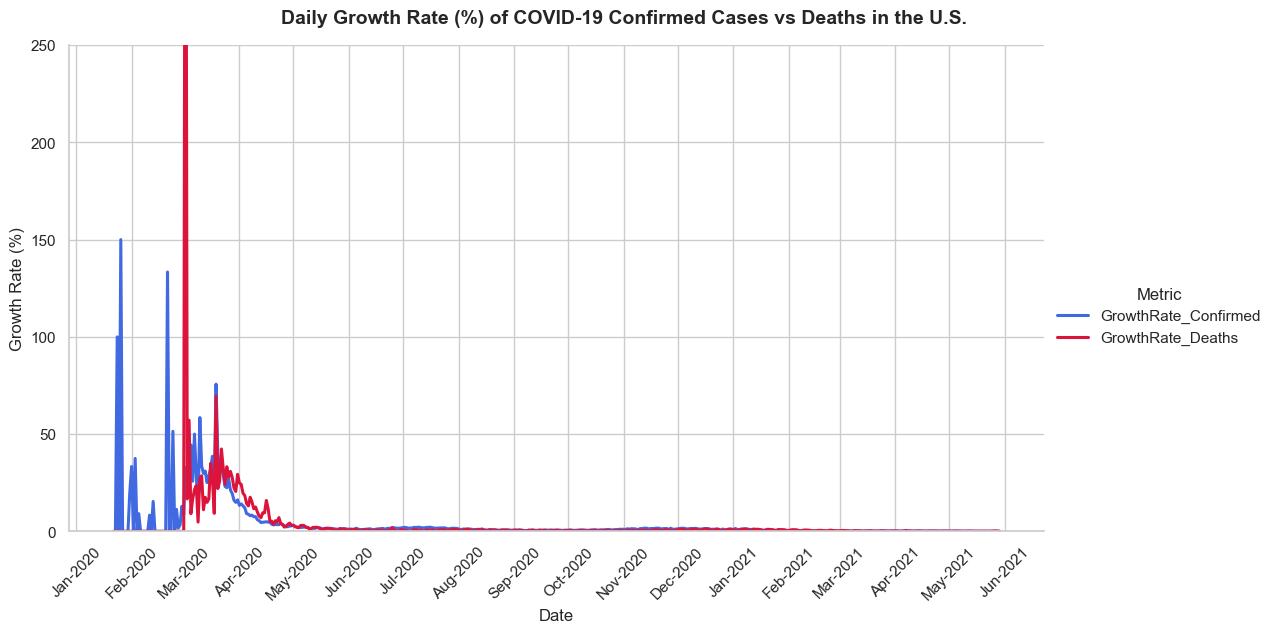

In [9]:
sns.set_theme(style="whitegrid")

# Create line plot with both metrics
g = sns.relplot(
    data=us_melted,
    x='ObservationDate', y='GrowthRate',
    kind='line', hue='Metric',  # color by metric type
    height=6, aspect=1.8,
    palette={'GrowthRate_Confirmed': 'royalblue', 'GrowthRate_Deaths': 'crimson'},
    linewidth=2.2
)

# Improve x-axis readability (show every 2nd month)
g.ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
g.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

# Titles and labels
g.set_axis_labels("Date", "Growth Rate (%)")
g.fig.suptitle("Daily Growth Rate (%) of COVID-19 Confirmed Cases vs Deaths in the U.S.",
               fontsize=14, weight='bold')
plt.subplots_adjust(top=0.92)

# Optional: limit y-axis to make early spikes clearer
g.set(ylim=(0, 250))

plt.show()
